In [1]:
%matplotlib inline


# MNE Epochs-based pipelines

This example shows how to use machine learning pipeline based on MNE Epochs
instead of Numpy arrays. This is useful to make the most of the MNE code base
and to embed EEG specific code inside sklearn pipelines.

We will compare different pipelines for P300:
- Logistic regression, based on MNE Epochs
- XDAWN and Logistic Regression (LR), based on MNE Epochs
- XDAWN extended covariance and LR on tangent space, based on Numpy


In [2]:
# Authors: Sylvain Chevallier
#
# License: BSD (3-clause)
# sphinx_gallery_thumbnail_number = 2

import warnings

import matplotlib.pyplot as plt
import pandas as pd
from mne.decoding import Vectorizer
from mne.preprocessing import Xdawn
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import moabb
from moabb.analysis.meta_analysis import (  # noqa: E501
    compute_dataset_statistics,
    find_significant_differences,
)
from moabb.analysis.plotting import paired_plot, summary_plot
from moabb.datasets import BNCI2014009
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import P300


warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
moabb.set_log_level("info")

## Loading Dataset

Load 2 subjects of BNCI 2014-009 dataset, with 3 session each



In [3]:
dataset = BNCI2014009()
dataset.subject_list = dataset.subject_list[:3]
datasets = [dataset]
paradigm = P300()

## Get Data (optional)

To get access to the EEG signals downloaded from the dataset, you could
use ``dataset.get_data([subject_id)`` to obtain the EEG as MNE Epochs, stored
in a dictionary of sessions and runs.
The ``paradigm.get_data(dataset=dataset, subjects=[subject_id])`` allows to
obtain the preprocessed EEG data, the labels and the meta information. By
default, the EEG is return as a Numpy array. With ``return_epochs=True``, MNE
Epochs are returned.



In [4]:
subject_list = [1]
sessions = dataset.get_data(subject_list)
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=subject_list)
epochs, labels, meta = paradigm.get_data(
    dataset=dataset, subjects=subject_list, return_epochs=True
)

MNE_DATA is not already configured. It will be set to default location in the home directory - C:\Users\Marcus\mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location


100%|#####################################| 18.5M/18.5M [00:00<00:00, 18.5GB/s]
SHA256 hash of downloaded file: beddf78f1834ddef15553e32c9d18c46bc9b3fd244ef3a8e2fe362066dfb027d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


## A Simple MNE Pipeline

Using ``return_epochs=True`` in the evaluation, it is possible to design a
pipeline based on MNE Epochs input. Let's create a simple one, that
reshape the input data from epochs, rescale the data and uses a logistic
regression to classify the data. We will need to write a basic Transformer
estimator, that complies with
`sklearn convention <https://scikit-learn.org/stable/developers/develop.html>`_.
This transformer will extract the data from an input Epoch, and reshapes into
2D array.



In [5]:
class MyVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        arr = X.get_data()
        self.features_shape_ = arr.shape[1:]
        return self

    def transform(self, X, y=None):
        arr = X.get_data()
        return arr.reshape(len(arr), -1)

We will define a pipeline that is based on this new class, using a scaler
and a logistic regression. This pipeline is evaluated across session using
ROC-AUC metric.



In [6]:
mne_ppl = {}
mne_ppl["MNE LR"] = make_pipeline(
    MyVectorizer(), StandardScaler(), LogisticRegression(penalty="l1", solver="liblinear")
)

mne_eval = CrossSessionEvaluation(
    paradigm=paradigm,
    datasets=datasets,
    suffix="examples",
    overwrite=True,
    return_epochs=True,
)
mne_res = mne_eval.process(mne_ppl)

2022-04-10 16:23:59,624 INFO MainThread moabb.evaluations.base Processing dataset: 009-2014
009-2014-CrossSession:   0%|          | 0/3 [00:00<?, ?it/s]2022-04-10 16:24:01,279 INFO MainThread moabb.evaluations.base MNE LR | 009-2014 | 1 | session_0: Score 0.908
2022-04-10 16:24:02,461 INFO MainThread moabb.evaluations.base MNE LR | 009-2014 | 1 | session_1: Score 0.918
2022-04-10 16:24:03,616 INFO MainThread moabb.evaluations.base MNE LR | 009-2014 | 1 | session_2: Score 0.909
009-2014-CrossSession:  33%|███▎      | 1/3 [00:04<00:08,  4.00s/it]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/009-2014/A02S.mat' to file 'C:\Users\Marcus\mne_data\MNE-bnci-data\database\data-sets\009-2014\A02S.mat'.

  0%|                                              | 0.00/18.5M [00:00<?, ?B/s]
  0%|1                                     | 50.2k/18.5M [00:00<00:44, 414kB/s]
  1%|2                                      | 116k/18.5M [00:00<00:37, 489kB/s]
  1%|3                           

009-2014-CrossSession:  67%|██████▋   | 2/3 [00:16<00:09,  9.20s/it]Downloading data from 'http://bnci-horizon-2020.eu/database/data-sets/009-2014/A03S.mat' to file 'C:\Users\Marcus\mne_data\MNE-bnci-data\database\data-sets\009-2014\A03S.mat'.

  0%|                                              | 0.00/18.5M [00:00<?, ?B/s]
  0%|1                                     | 50.2k/18.5M [00:00<00:53, 343kB/s]
  1%|2                                      | 116k/18.5M [00:00<00:37, 495kB/s]
  1%|4                                      | 230k/18.5M [00:00<00:28, 649kB/s]
  2%|7                                      | 378k/18.5M [00:00<00:19, 915kB/s]
  3%|#2                                    | 624k/18.5M [00:00<00:12, 1.39MB/s]
  5%|#8                                    | 902k/18.5M [00:00<00:10, 1.63MB/s]
  7%|##4                                  | 1.25M/18.5M [00:00<00:08, 2.12MB/s]
  9%|###4                                 | 1.72M/18.5M [00:00<00:05, 2.85MB/s]
 13%|####7                         

## Advanced MNE Pipeline

In some case, the MNE pipeline should have access to the original labels from
the dataset. This is the case for the XDAWN code of MNE. One could pass
`mne_labels` to evaluation in order to keep this label.
As an example, we will define a pipeline that computes an XDAWN filter, rescale,
then apply a logistic regression.



In [7]:
mne_adv = {}
mne_adv["XDAWN LR"] = make_pipeline(
    Xdawn(n_components=5, reg="ledoit_wolf", correct_overlap=False),
    Vectorizer(),
    StandardScaler(),
    LogisticRegression(penalty="l1", solver="liblinear"),
)
adv_eval = CrossSessionEvaluation(
    paradigm=paradigm,
    datasets=datasets,
    suffix="examples",
    overwrite=True,
    return_epochs=True,
    mne_labels=True,
)
adv_res = mne_eval.process(mne_adv)

2022-04-10 16:24:39,448 INFO MainThread moabb.evaluations.base Processing dataset: 009-2014
009-2014-CrossSession:   0%|          | 0/3 [00:00<?, ?it/s]2022-04-10 16:24:41,136 INFO MainThread moabb.evaluations.base XDAWN LR | 009-2014 | 1 | session_0: Score 0.905
2022-04-10 16:24:42,306 INFO MainThread moabb.evaluations.base XDAWN LR | 009-2014 | 1 | session_1: Score 0.880
2022-04-10 16:24:43,531 INFO MainThread moabb.evaluations.base XDAWN LR | 009-2014 | 1 | session_2: Score 0.870
009-2014-CrossSession:  33%|███▎      | 1/3 [00:04<00:08,  4.09s/it]2022-04-10 16:24:44,691 INFO MainThread moabb.evaluations.base XDAWN LR | 009-2014 | 2 | session_0: Score 0.943
2022-04-10 16:24:45,592 INFO MainThread moabb.evaluations.base XDAWN LR | 009-2014 | 2 | session_1: Score 0.945
2022-04-10 16:24:46,395 INFO MainThread moabb.evaluations.base XDAWN LR | 009-2014 | 2 | session_2: Score 0.925
009-2014-CrossSession:  67%|██████▋   | 2/3 [00:06<00:03,  3.37s/it]2022-04-10 16:24:47,789 INFO MainThread 

## Numpy-based Pipeline

For the comparison, we will define a Numpy-based pipeline that relies on
pyriemann to estimate XDAWN-extended covariance matrices that are projected
on the tangent space and classified with a logistic regression.



In [8]:
sk_ppl = {}
sk_ppl["RG LR"] = make_pipeline(
    XdawnCovariances(nfilter=5, estimator="lwf", xdawn_estimator="scm"),
    TangentSpace(),
    LogisticRegression(penalty="l1", solver="liblinear"),
)
sk_eval = CrossSessionEvaluation(
    paradigm=paradigm,
    datasets=datasets,
    suffix="examples",
    overwrite=True,
)
sk_res = sk_eval.process(sk_ppl)

2022-04-10 16:24:51,944 INFO MainThread moabb.evaluations.base Processing dataset: 009-2014
009-2014-CrossSession:   0%|          | 0/3 [00:00<?, ?it/s]2022-04-10 16:24:55,736 INFO MainThread moabb.evaluations.base RG LR | 009-2014 | 1 | session_0: Score 0.948
2022-04-10 16:24:59,150 INFO MainThread moabb.evaluations.base RG LR | 009-2014 | 1 | session_1: Score 0.939
2022-04-10 16:25:02,555 INFO MainThread moabb.evaluations.base RG LR | 009-2014 | 1 | session_2: Score 0.945
009-2014-CrossSession:  33%|███▎      | 1/3 [00:10<00:21, 10.62s/it]2022-04-10 16:25:06,321 INFO MainThread moabb.evaluations.base RG LR | 009-2014 | 2 | session_0: Score 0.970
2022-04-10 16:25:09,703 INFO MainThread moabb.evaluations.base RG LR | 009-2014 | 2 | session_1: Score 0.976
2022-04-10 16:25:13,093 INFO MainThread moabb.evaluations.base RG LR | 009-2014 | 2 | session_2: Score 0.967
009-2014-CrossSession:  67%|██████▋   | 2/3 [00:21<00:10, 10.57s/it]2022-04-10 16:25:16,877 INFO MainThread moabb.evaluations.

## Combining Results

Even if the results have been obtained by different evaluation processes, it
is possible to combine the resulting DataFrames to analyze and plot the
results.



In [9]:
all_res = pd.concat([mne_res, adv_res, sk_res])

In [12]:
print(sk_res)

      score      time  samples subject    session  channels  n_sessions  \
0  0.948047  3.419633   1152.0       1  session_0        16           3   
1  0.939019  3.405098   1152.0       1  session_1        16           3   
2  0.944944  3.394088   1152.0       1  session_2        16           3   
3  0.969944  3.378578   1152.0       2  session_0        16           3   
4  0.976324  3.374555   1152.0       2  session_1        16           3   
5  0.967166  3.378924   1152.0       2  session_2        16           3   
6  0.743490  3.397660   1152.0       3  session_0        16           3   
7  0.950629  3.608205   1152.0       3  session_1        16           3   
8  0.906554  3.757547   1152.0       3  session_2        16           3   

    dataset pipeline  
0  009-2014    RG LR  
1  009-2014    RG LR  
2  009-2014    RG LR  
3  009-2014    RG LR  
4  009-2014    RG LR  
5  009-2014    RG LR  
6  009-2014    RG LR  
7  009-2014    RG LR  
8  009-2014    RG LR  


We could compare the Euclidean and Riemannian performance using a `paired_plot`



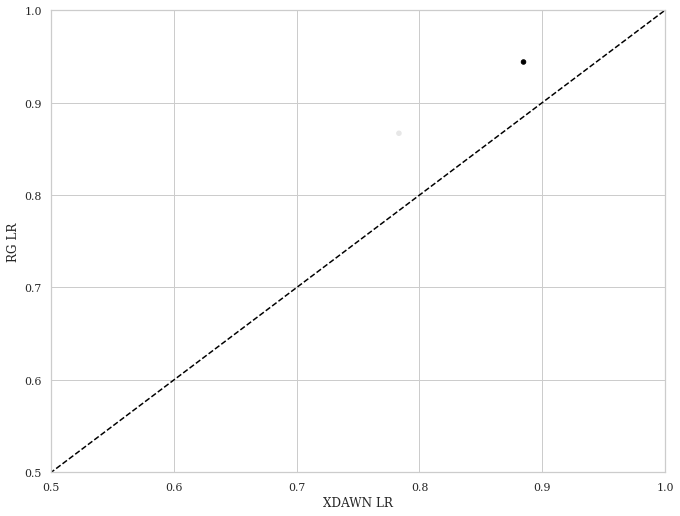

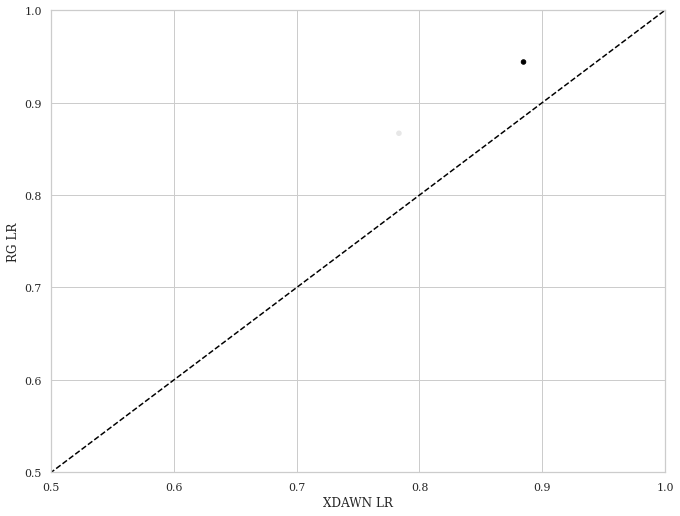

In [10]:
paired_plot(all_res, "XDAWN LR", "RG LR")

All the results could be compared and statistical analysis could highlight the
differences between pipelines.



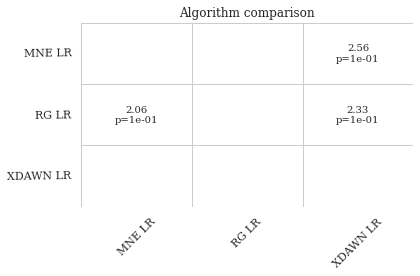

In [11]:
stats = compute_dataset_statistics(all_res)
P, T = find_significant_differences(stats)
summary_plot(P, T)
plt.show()